# Epidemic threshold

We're familiar with the idea that some diseases are more infectious than others. In real-world epidemics this is emobodied in the basic case reproduction number $R_0$, which counts the number of other infections arising on average from every infection. In modelling it is embodied in $p_{\mathit{infect}}$, the probability that a contact leads to an infection.

But how infectious does a disease have to be to cause an epidemic? &ndash; that is to say, to create infection in a sizeable fraction of a population?

Clearly these two ideas are related: a disease that passes easily between people will be more likely to pass to more people. But it turns out that the relationship isn't as simple as we might expect. It's affected by a number of factors, including the disease parameters and the topology of the network &ndash; in other words, by the disease *and* the environment in which it finds itself. This is important: we're limited in what we can do about the basic infectiousness of a disease since that's defined by its biology, but the significance of topology opens-up the possibilty of countermeasures at a population level. 

Looking back at the SIR model on an ER network, we see patterns in the way it spreads. For very low values of $\langle k \rangle$, the mean degree of the network, the epidemic never really "gets going". We can think of this as being what happens when the disease begins in population that's too disconnected to spread the disease before the infected individuals recover (or die). This is the other extreme to the fully connected network where *all* connections are in play and the propagation of the disease depends solely on the relationship between the rates of infection and recovery.

Let's ask a different question, though. If we fix the topology but change the infectivity, what happens to the numbers of people infected? We already know that in the fully-mixed case a very small change in infectivity results in a massive change in the size of the epidemic. But that was in a somewhat unrealistic case.

A related question is: for a particular topology, is there a characteristic degree of infectiousness that's needed to start an epidemic, below which one doesn't occur? To put it another way, is there an **epidemic threshold** that a disease must exceed in order to go epidemic?

(sec:thresholds-er)=
## The epidemic threshold of an ER network

Let's look at the case for an ER network, the simplest model we have. (We've already accepted that it's not a great model of human contact networks, but we'll refine this later.)


In [8]:
import numpy
import networkx
import epyc
import epydemic
import pandas

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import matplotlib.pyplot as plt
import seaborn
matplotlib.style.use('seaborn')
seaborn.set_context("notebook", font_scale=1.5)

To locate the epidemic threshold (assuming it exists), we need to simulate epidemics on networks across a range of infectiousness &ndash; that is to say, for different values of $p_{\mathit{infect}}$. If we want to test, shall we say, 50 different values of $p_{\mathit{infect}}$ we'll need to run at least 50 experiments, one per value.

But we know there's a lot of randomness going on here as well. The networks we create are random; we seed them randomly with infected individuals; and the disease progression is itself a random process. What if, by chance, we chose as the "seed" individuals a group of people who were all right next to each other, with few other people to infect? What if, by chance, the infection failed to transmit a large number of times, and so died out?

There are a number of ways to deal with these issues, but the safest, most general, and most straightforward one is to conduct lots of trials and look at the patterns in the results, possibly then taking averages of the trials to find the "expected result" for a given value of $p_{\mathit{infect}}$. By repeating the experiment we reduce the influence of chances that "unlikely" combinations of circumstances will sway the answer.

```{margin}
To professional researchers, anyway: not so much for hobby use, although cloud computing provides access to fairly affordable computing resources.
```

The disadvantage of this approach is that it involves doing a lot more simulation, which in turn requires more computing power. Fortunately the scale of compute power we need is readily available nowadays, and we can conduct experiments using "clusters" of computers configured identically and each performing a share of the experiments we need doing..

In [29]:
lab = epyc.ClusterLab(profile='hogun', notebook=epyc.JSONLabNotebook('datasets/threshold-er.json'))
with lab.sync_imports():
    import time
    import networkx
    import epyc
    import epydemic
    import numpy
print('{n} engines available'.format(n = lab.numberOfEngines()))

importing time on engine(s)
importing networkx on engine(s)
importing epyc on engine(s)
importing epydemic on engine(s)
importing numpy on engine(s)
importing mpmath on engine(s)
72 engines available


In [2]:
# from https://nbviewer.jupyter.org/gist/minrk/4470122
def pxlocal(line, cell):
    ip = get_ipython()
    #ip.run_cell_magic("px", line, cell)
    ip.run_cell(cell)
get_ipython().register_magic_function(pxlocal, "cell")    

Because we're wanting to create a lot of random networks, we'll add code to the computational experiment to create them as required. Otherwise we'd run the risk of doing too many experiments on the same random network, and being affected by any features it happened to have.

In [3]:
%%pxlocal

class ERNetworkDynamics(epydemic.StochasticDynamics):
    
    # Experimental parameters
    N = 'N'
    KMEAN = 'kmean'
    
    def __init__(self, p):
        super(ERNetworkDynamics, self).__init__(p)
        
    def configure(self, params):
        super(ERNetworkDynamics, self).configure(params)
        
        # build a random ER network with the given parameters
        N = params[self.N]
        kmean = params[self.KMEAN]
        pEdge = (kmean + 0.09) / N
        g = networkx.gnp_random_graph(N, pEdge)
        self.setNetworkPrototype(g)

We will conduct our exploration on the same sort of network we've used before &ndash; $10^4$ nodes with $\langle k \rangle = 40$ &ndash; over 50 values of $p_{\mathit{infect}}$.

In [31]:
# test network
lab[ERNetworkDynamics.N] = 10000
lab[ERNetworkDynamics.KMEAN] = 40

# disease parameters
lab[epydemic.SIR.P_INFECTED] = 0.001
lab[epydemic.SIR.P_REMOVE] = 0.002
lab[epydemic.SIR.P_INFECT] = numpy.linspace(0.00001, 0.0002, num=50)

Finally, we'll set up the number of repetitions. For each point in the space we'll create 10 random networks and run the experiment 10 times on each, re-seeding the network randomly with infected individuals each time. 

In [32]:
m = epydemic.SIR()
e = ERNetworkDynamics(m)
rc = lab.runExperiment(epyc.RepeatedExperiment(epyc.RepeatedExperiment(e, 10), 10))

A lot of computation now ensues, and eventually we get the results back.

In [9]:
df = epyc.JSONLabNotebook('datasets/threshold-er.json').dataframe()

We can now look at the data. Let's begin by plotting the results of *all* the experiments we did &ndash; 5000 datapoints in all &ndash; to see that shape of the results.

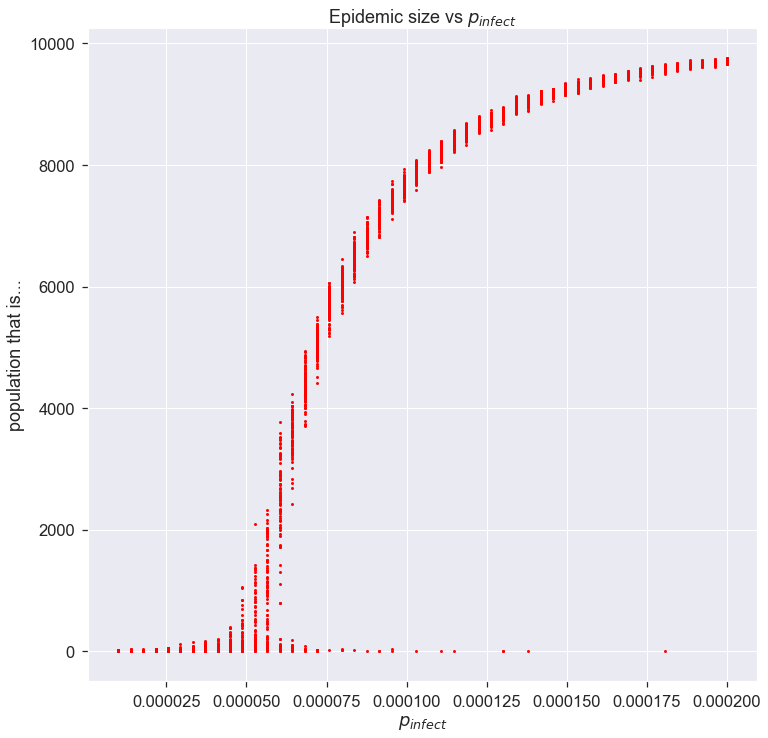

In [10]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()

# plot the size of the removed population
ax.plot(df[epydemic.SIR.P_INFECT], df[epydemic.SIR.REMOVED], 'r.')
ax.set_xlabel('$p_{\\mathit{infect}}$')
ax.set_ylabel('population that is...')
ax.set_title('Epidemic size vs $p_{\\mathit{infect}}$')

plt.show()

What does this show? The two extremes of the curve are easy. Low infectivity (at the left) means that almost none of the poopulation becomes infected, as the disease dies out quickly. High infectivity (at the right) causes almost all the population to become infected &ndash; although not quite all, it would seem.

But what about the middle part of the curve, where it transitions between these extrema? There are two things to notice. Firstly, for each value of $p_{\mathit{infect}}$ there are a *range of possible results*, many different possible epidemics that might happen. This is the essence of a stochastic process: you can get different results for the same starting conditions. Remember that we did 10 experiments on each random network, and still we get different answers, so there's something inherently variable at work. But secondly, notice that for most of the values of $p_{\mathit{infect}}$ the results are "clustered" into a small line. Remember that we ran experiments on 10 different networks, so there's clearly also some commonality at work in the process where it gives closely-related (but different) results for different networks and seeds of infection.

Let's zoom-in on part of the curve so see the variation in more detail.

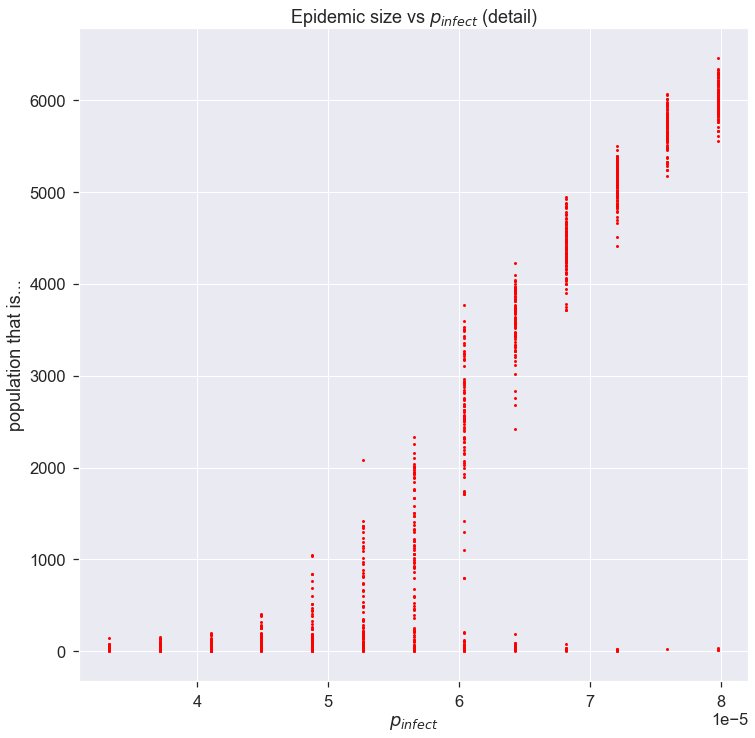

In [11]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()

# plot the size of the removed population
pInfects = df[[pInfect > 0.00003 and pInfect < 0.00008 for pInfect in df[epydemic.SIR.P_INFECT]]]
ax.plot(pInfects[epydemic.SIR.P_INFECT], pInfects[epydemic.SIR.REMOVED], 'r.')
ax.set_xlabel('$p_{\\mathit{infect}}$')
ax.set_ylabel('population that is...')
ax.set_title('Epidemic size vs $p_{\\mathit{infect}}$ (detail)')

plt.show()

As $p_{\mathit{infect}}$ increases the possible sizes of the epidemic start to vary, from nothing up to maybe a thousand people. As we keep increasing $p_{\mathit{infect}}$ the range keeps increasing, but still with some instances of the epidemic not getting started. But as we *keep* increasing $p_{\mathit{infect}}$ the epidemic starts being consistently larger, with a smaller chance of it failing to take hold, and the size starts to become more consistent as well. Eventually we have a situation in which around 98% of the experiments result in an epidemic that infects around 60% of the population.

```{margin}
Error bars usually show the standard deviation (also called the standard error) of the dataset at that point.
```

We can look at this data slightly differently, by plotting the mean size of epidemic for each value of $p_{\mathit{infect}}$: the average of our 100 experiments. But we should also keep track of the errors, and the standard way of doing this is to include error bars on the plot.   

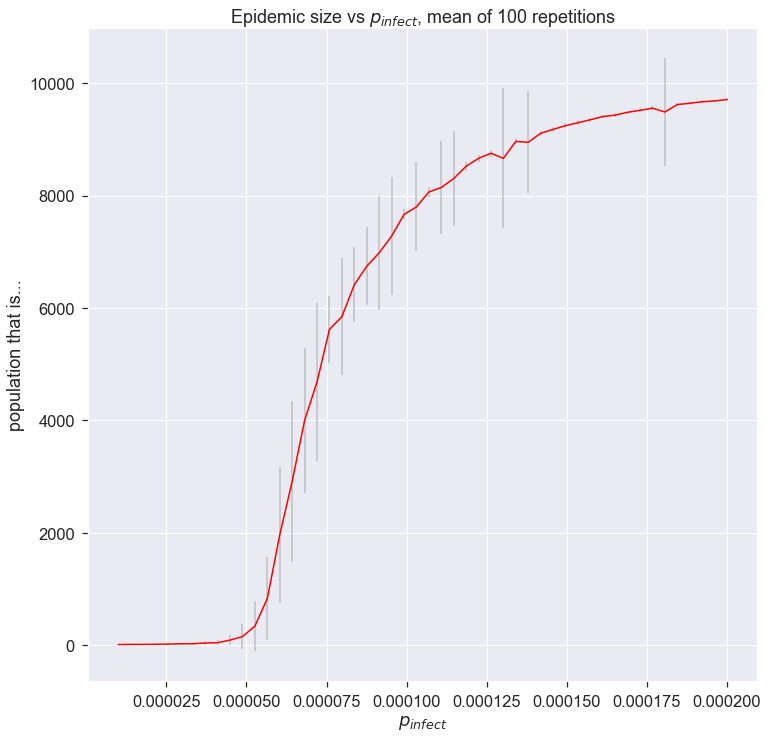

In [12]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()

# plot the size of the removed population
pInfects = sorted(df[epydemic.SIR.P_INFECT].unique())
repetitions = int(len(df[epydemic.SIR.P_INFECT]) / len(pInfects))
removeds = []
stdErrors = []
for pInfect in pInfects:
    removeds.append(df[df[epydemic.SIR.P_INFECT] == pInfect][epydemic.SIR.REMOVED].mean())
    stdErrors.append(df[df[epydemic.SIR.P_INFECT] == pInfect][epydemic.SIR.REMOVED].std())
ax.errorbar(pInfects, removeds, yerr=stdErrors, fmt='r-', ecolor='0.75', capsize=2.0)
ax.set_xlabel('$p_{\\mathit{infect}}$')
ax.set_ylabel('population that is...')
ax.set_title('Epidemic size vs $p_{\\mathit{infect}}$' + ', mean of {r} repetitions'.format(r=repetitions))

plt.show()

```{margin}

The "variance of the variance" is also called the *skewness*.
```

So there's still a lot of variance in the results: we could see that by plotting them "raw". the error bars just present the same information in a statistical manner. We can also see that the variance changes quite considerably: there's variance in the variance. Both of these suggest that we should do more experiments to see whether the values converge more closely to cluster around their mean. One advantage of simulation is that we can easily do exactly this, simply by crunching more numbers &ndash; a luxury not present in real-world epidemiology.

## Questions for discussion

- Where is all this variance coming from? &ndash; aren't we getting exact answers by running simulations in a computer?
- The existence of an epidemic threshold suggests that some diseases never become epidemics. Is that right?